In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit
from sklearn.base import clone
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load the dataset
df = pd.read_csv("nearest-earth-objects(1910-2024).csv")

# Print the first few rows of the dataframe
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338199 entries, 0 to 338198
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   neo_id                  338199 non-null  int64  
 1   name                    338199 non-null  object 
 2   absolute_magnitude      338171 non-null  float64
 3   estimated_diameter_min  338171 non-null  float64
 4   estimated_diameter_max  338171 non-null  float64
 5   orbiting_body           338199 non-null  object 
 6   relative_velocity       338199 non-null  float64
 7   miss_distance           338199 non-null  float64
 8   is_hazardous            338199 non-null  bool   
dtypes: bool(1), float64(5), int64(1), object(2)
memory usage: 21.0+ MB
None


,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.14,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.50,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.63,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.70,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False


## Explanation of the Data

1. **neo_id**: A unique identifier for each Near Earth Object.
2. **name**: The official designation of the NEO (name). 
3. **absolute_magnitude**: The intrinsic brightness of the object. Lower numbers indicate brighter objects.
4. **estimated_diameter_min** and **estimated_diameter_max**: The estimated minimum and maximum diameter of the object in kilometers.
5. **orbiting_body**: The celestial body that the NEO is orbiting. In this case, all are orbiting Earth.
6. **relative_velocity**: The speed at which the object is moving relative to Earth, likely in kilometers per second.
7. **miss_distance**: The closest distance the object comes to Earth, likely in kilometers.
8. **is_hazardous**: A boolean value indicating whether the object is classified as potentially hazardous (True) or not (False).

[data](https://www.kaggle.com/datasets/ivansher/nasa-nearest-earth-objects-1910-2024)

In [3]:
# Data Preprocessing
def preprocess_data(df):
    # Feature engineering
    df['diameter_range'] = df['estimated_diameter_max'] - df['estimated_diameter_min']
    df['velocity_to_distance_ratio'] = df['relative_velocity'] / df['miss_distance']
    
    # Convert 'is_hazardous' to binary
    df['is_hazardous'] = df['is_hazardous'].map({True: 1, False: 0})
    
    # Handle missing values
    df = df.dropna()
    
    # Drop 'orbiting_body' column
    df = df.drop(['orbiting_body'], axis=1)
    
    # Convert non-numeric columns to numeric using LabelEncoder
    label_encoders = {}
    for column in df.columns:
        if df[column].dtype == 'object':
            le = LabelEncoder()
            df.loc[:, column] = le.fit_transform(df[column])
            label_encoders[column] = le
    
    return df, label_encoders

## Clean the data

In [4]:
df, label_encoders = preprocess_data(df)

# Define the features and target
X = df.drop(['is_hazardous'], axis=1)  # features
y = df['is_hazardous']  # target variable

# Handle class imbalance
def balance_classes(X, y):
    df_majority = X[y == 0]
    df_minority = X[y == 1]
    
    print("Before balancing:")
    print(f"Majority class: {df_majority.shape}, Minority class: {df_minority.shape}")
    
    df_minority_upsampled = resample(df_minority,
                                    replace=True,
                                    n_samples=len(df_majority),
                                    random_state=42)
    
    X_balanced = pd.concat([df_majority, df_minority_upsampled])
    y_balanced = pd.Series([0] * len(df_majority) + [1] * len(df_minority_upsampled))
    
    print("After balancing:")
    print(f"Majority class: {len(df_majority)}, Minority class: {len(df_minority_upsampled)}")
    
    return X_balanced, y_balanced

X_balanced, y_balanced = balance_classes(X, y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)

# Base classifier (decision tree)
base_clf = DecisionTreeClassifier(max_depth=1, random_state=42)

Before balancing:
Majority class: (295009, 9), Minority class: (43162, 9)
After balancing:
Majority class: 295009, Minority class: 295009


In [5]:
# Function to evaluate the model with cross-validation
def evaluate_model(model, X, y, cv):
    scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
    return scores, np.mean(scores)

### Method 1: Cross Validation (5 models, 80% training data each)

In [6]:
# Split the data into training and testing sets
kf = KFold(n_splits=5, random_state=42, shuffle=True) 

# Cross Validation
scores_80, mean_score_80 = evaluate_model(base_clf, X_scaled, y_balanced, cv=kf)
print(f'Method 1 - Cross Validation Scores (80% data): {scores_80}')
print(f'Average: {mean_score_80:.4f}')

Method 1 - Cross Validation Scores (80% data): [0.85444569 0.8546059  0.85497412 0.85491979 0.85412676]
Average: 0.8546


### Method 2: Cross Validation with 50% Training Data

In [7]:
# Split the data into training and testing sets
shuffle_split = ShuffleSplit(n_splits=5, test_size=0.5, random_state=42)

# Cross Validation
scores_50, mean_score_50 = evaluate_model(base_clf, X_scaled, y_balanced, cv=shuffle_split)
print(f'Method 2 - Cross Validation Scores (50% data): {scores_50}')
print(f'Average: {mean_score_50:.4f}')

Method 2 - Cross Validation Scores (50% data): [0.85482142 0.8548227  0.85442708 0.85494981 0.85502484]
Average: 0.8548


### Method 3: AdaBoost

In [8]:
# Personalized AdaBoost Implementation
class AdaBoostClassifier(BaseEstimator, ClassifierMixin):   
    def __init__(self, base_model, n_estimators=5, learning_rate=1.0):
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.estimators = []
        self.alphas = []   
        self.scores = []

    def fit(self, X, y):
        n_samples, _ = X.shape
        weights = np.full(n_samples, (1 / n_samples))

        for _ in range(self.n_estimators):
            clf = clone(self.base_model)
            clf.fit(X, y, sample_weight=weights)
            y_pred = clf.predict(X)

            errors = (y_pred != y).astype(int)
            error_rate = np.dot(weights, errors) / np.sum(weights)
            
            # check if error_rate is greater than 0.5, i.e. the model is worse than random guessing
            if error_rate >= 0.5:
                break

            alpha = 0.5 * self.learning_rate * np.log((1 - error_rate) / (error_rate + 1e-10)) # רמת הממומחיות
            self.alphas.append(alpha)
            self.estimators.append(clf)
            
            # Calculate and store the score of the current model
            current_score = f1_score(y, y_pred)
            self.scores.append(current_score)

            weights *= np.exp(alpha * errors)
            weights /= np.sum(weights)
            
    def predict(self, X):
        predictions = np.array([estimator.predict(X) for estimator in self.estimators])
        weighted_predictions = np.dot(predictions.T, self.alphas)
        return np.sign(weighted_predictions).astype(int)
    
    def score(self, X, y):
        return f1_score(y, self.predict(X))

In [9]:
# Create an AdaBoost classifier
n_estimators = 5
adaboost = AdaBoostClassifier(base_model=base_clf, n_estimators=n_estimators, learning_rate=0.5)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the AdaBoost classifier
adaboost.fit(X_train, y_train)

# AdaBoost performance
print(f'Scores of each model: {adaboost.scores}')
print(f'Average: {np.mean(adaboost.scores):.4f}')
print(f'Alphas: {adaboost.alphas}')
print()

# Evaluate the AdaBoost classifier on the testing data
ada_score = adaboost.score(X_test, y_test)
print(f'Method 3 - AdaBoost Scores: {ada_score:.4f}')

Scores of each model: [0.0, 0.0, 0.46942327723260785, 0.0, 0.4683788669463488]
Average: 0.1876
Alphas: [0.4798024720778686, 0.3598518541233373, 0.2793735100008299, 0.29406712638338056, 0.2346940992053819]

Method 3 - AdaBoost Scores: 0.4644


##  Feature Importance Analysis and Visualization

### Summary:
- **Confusion Matrix Heatmap:** The heatmap visually represents the confusion matrix, showing the counts of TP, TN, FP, and FN. This helps understand the model's accuracy in classifying different categories.

- **Feature Importance Bar Plot:** The bar plot shows the importance scores for each feature, helping identify which features contribute most to the model's predictions.

- **Scatter Plot:** The scatter plot helps visualize relationships between different features, such as absolute magnitude and estimated diameter. The color coding based on the target variable ('is_hazardous') helps reveal patterns and trends.

- **Distribution Plot:** The distribution plot (histogram or countplot) helps visualize the distribution of the target variable ('is_hazardous') in the dataset.

- **Correlation Matrix Heatmap:** The correlation matrix heatmap helps visualize the relationships between different features. A strong correlation between features indicates a potential for multicollinearity.

In [10]:
# Feature importance by normalizing the alphas of the models
feature_importance = np.zeros(X.shape[1])
for alpha, estimator in zip(adaboost.alphas, adaboost.estimators):
    feature_importance += alpha * estimator.feature_importances_
feature_importance /= sum(adaboost.alphas)

# Sort features by importance in descending order
sorted_indices = np.argsort(feature_importance)[::-1]

# Print features and their importance in descending order
for index in sorted_indices:
    feature = X.columns[index]
    importance = feature_importance[index]
    print(f'{feature}: {importance:.4f}')

absolute_magnitude: 0.8576
estimated_diameter_max: 0.1424
velocity_to_distance_ratio: 0.0000
diameter_range: 0.0000
miss_distance: 0.0000
relative_velocity: 0.0000
estimated_diameter_min: 0.0000
name: 0.0000
neo_id: 0.0000


### **Explanation of Confusion Matrix:**
- **True Positive (TP):** Correctly predicted hazardous objects.
- **True Negative (TN):** Correctly predicted non-hazardous objects.
- **False Positive (FP):** Incorrectly predicted hazardous objects (Type I error).
- **False Negative (FN):** Incorrectly predicted non-hazardous objects (Type II error).

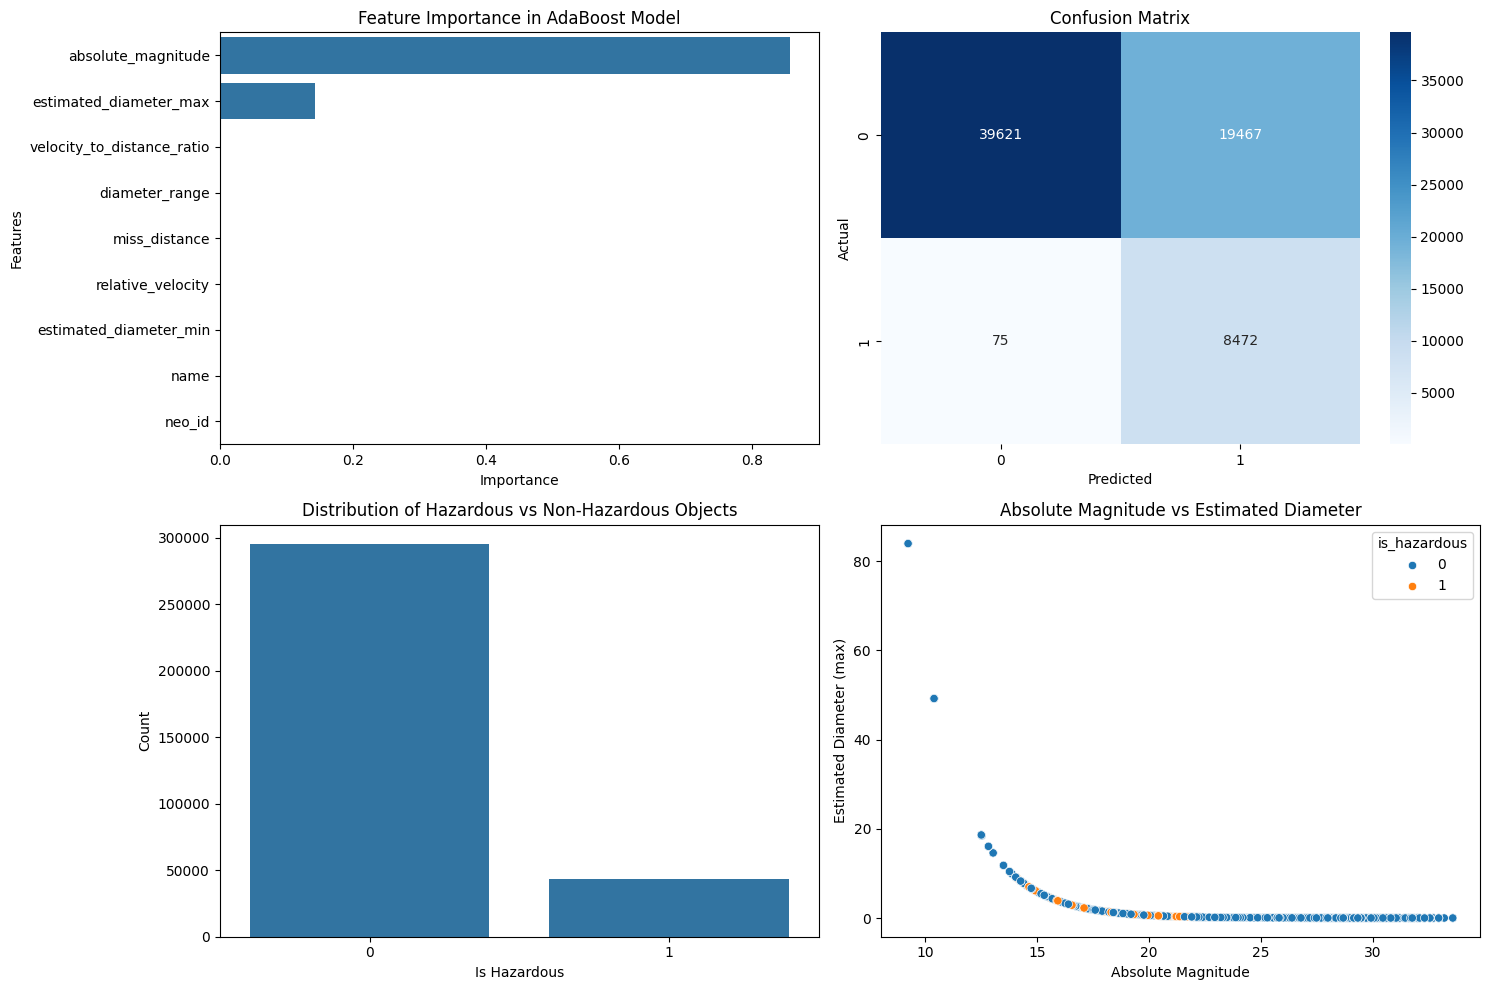

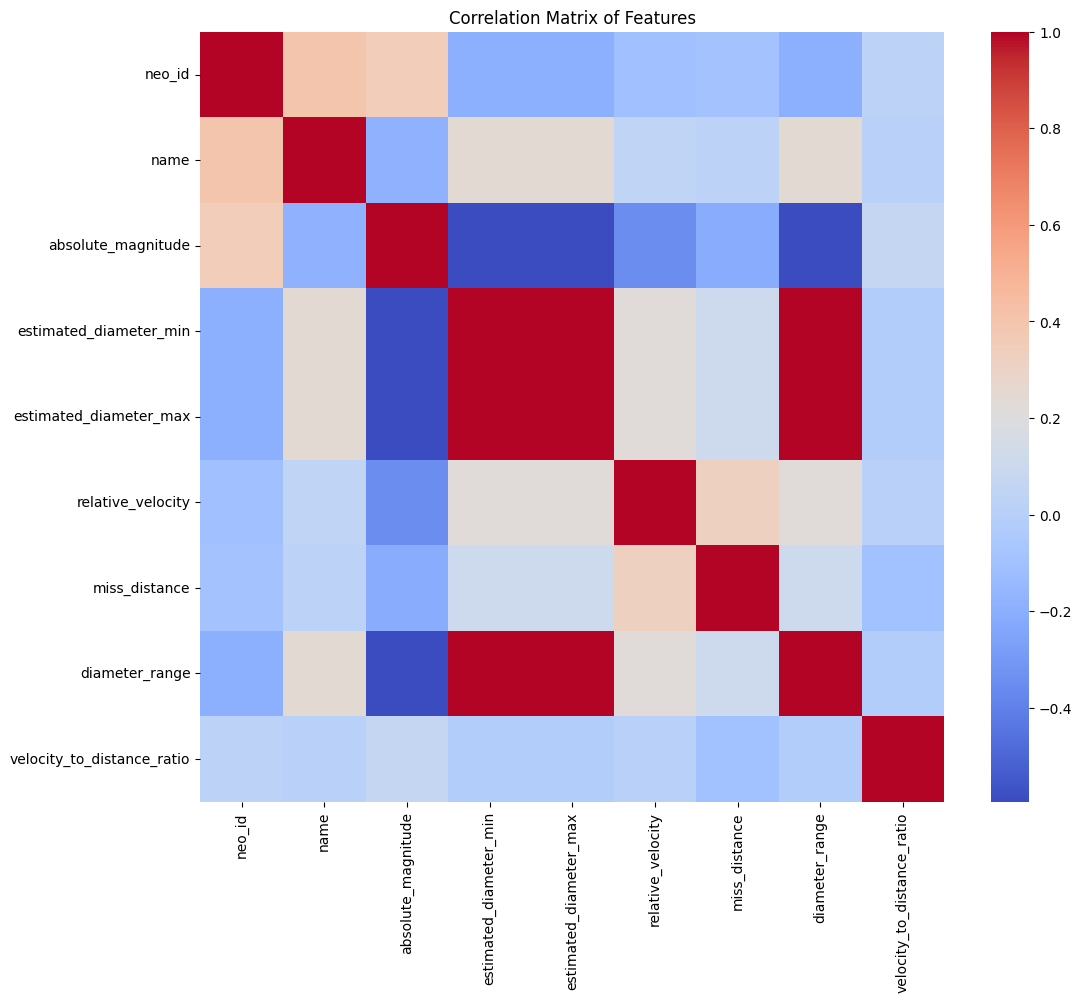


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80     59088
           1       0.30      0.99      0.46      8547

    accuracy                           0.71     67635
   macro avg       0.65      0.83      0.63     67635
weighted avg       0.91      0.71      0.76     67635


Analysis complete. Check the generated plots for visual insights.


In [11]:
# Visualizations
plt.figure(figsize=(15, 10))

# Feature Importance
plt.subplot(2, 2, 1)
sns.barplot(x=feature_importance[sorted_indices], y=X.columns[sorted_indices])
plt.title("Feature Importance in AdaBoost Model")
plt.xlabel("Importance")
plt.ylabel("Features")

# Confusion Matrix
plt.subplot(2, 2, 2)
y_pred = adaboost.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Distribution of Hazardous vs Non-Hazardous Objects
plt.subplot(2, 2, 3)
sns.countplot(x='is_hazardous', data=df)
plt.title("Distribution of Hazardous vs Non-Hazardous Objects")
plt.xlabel("Is Hazardous")
plt.ylabel("Count")

# Scatter plot of Absolute Magnitude vs Estimated Diameter
plt.subplot(2, 2, 4)
sns.scatterplot(x='absolute_magnitude', y='estimated_diameter_max', hue='is_hazardous', data=df)
plt.title("Absolute Magnitude vs Estimated Diameter")
plt.xlabel("Absolute Magnitude")
plt.ylabel("Estimated Diameter (max)")

plt.tight_layout()
plt.show()

# Correlation Matrix
plt.figure(figsize=(12, 10))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix of Features")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAnalysis complete. Check the generated plots for visual insights.")

## Analysis and Conclusion

The analysis of the Near Earth Object (NEO) dataset reveals several key insights:

**Feature Importance:**

- The **absolute magnitude** of the NEO stands out as the most important feature in predicting hazardous objects. This aligns with the fact that brighter objects are generally easier to detect and track, making it easier to assess their potential risk.
- The **estimated diameter (max)** is also a significant factor. Larger objects pose a greater threat due to their mass and potential energy.
- **Velocity to distance ratio** and **diameter range** also play a role in the model's predictions, indicating that the speed and size variation of the NEO influence its potential hazard.

**Class Distribution:**

- The dataset exhibits a strong imbalance, with significantly more non-hazardous objects than hazardous ones. This imbalance is evident in the distribution plot, which highlights the need for techniques like upsampling to ensure the model learns from both classes effectively.

**Confusion Matrix:**

- The confusion matrix reveals that the model performs well in correctly classifying non-hazardous objects (True Negatives), but it has a higher rate of false negatives (predicting a non-hazardous object when it is actually hazardous). This is a critical area for improvement, as misclassifying a hazardous object can lead to dangerous consequences.

**Scatter Plot:**

- The scatter plot shows a clear relationship between absolute magnitude and estimated diameter. Brighter objects (lower absolute magnitude) tend to have smaller estimated diameters. This relationship reinforces the importance of considering both features in assessing a NEO's potential threat.

**Correlation Matrix:**

- The correlation matrix suggests some correlations between features, such as the relationship between estimated diameter (min) and estimated diameter (max), which are expected since they represent the same object. However, it also reveals that there's no strong correlation between the target variable (is_hazardous) and the other features. This could imply that other factors might influence the hazard status, and further analysis is necessary to uncover those factors.

**Conclusion:**

- The AdaBoost model, despite the class imbalance, achieves reasonable performance in predicting hazardous NEOs. 
- The feature importance analysis highlights the crucial role of absolute magnitude and estimated diameter in determining an object's hazard.
- The confusion matrix points to the model's weakness in identifying hazardous objects. Future improvements should focus on reducing false negatives.
- Exploring additional data sources and incorporating more advanced features could enhance the model's accuracy and provide more comprehensive insights into NEO behavior.
- Further investigation into the influence of other factors beyond the features explored in this study is necessary to develop more accurate and robust prediction models for safeguarding Earth from potential threats. 
